# **Speech Emotion Recogition (Classification) in real-time using Deep LSTM layers**
### ***A Deep Learning LSTM based model with keras.***
---

### Final project (B.Sc. requirement)  
Development by **Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.





# **ABSTRACT**
This study aims to investigate and implement an Artificial Intelligence (AI) model that will analyze a speech audio input in real-time, identify and present the expressed emotion within it.

This classification model is developed in a Deep Learning method, meaning a Deep Neural Network (DNN) while an advanced model for time-series analysis has been chosen, which is the Long Short-Term Memory (LSTM).

For the train of the model, expressed emotions by actors have been used from The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) from the Ryerson University, as well as the Toronto Emotional Speech Set (TESS) from the University of Toronto.

Results had shown an accuracy of 87.23% of emotional recognition from speech.

This notebook contains the first part of the study, ahead of a real-time system for speech emotion recognition system (SER).


---



# **LIBRARIES & GOOGLE AUTH**

In [62]:

import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn 

import os
import librosa
import numpy as np
from pydub import AudioSegment
from pydub import effects
import time
import noisereduce as nr  # Import the noise reduction library



# **THE DATA**
The speech emotion audio databases used:

- **The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.
  - **1440 files** = 24 actors x 60 trails per actor
  - **8 Emotions** (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

- **Toronto Emotional Speech Set (TESS)**
https://tspace.library.utoronto.ca/handle/1807/24487
  - These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions described below.
Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.
  - **2800 files** = 2 actors x 200 pharses x 7 emotions
  - **7 Emotions** (neutral, happiness, sadness, anger, fear, disgust, pleasant surprise)
   - ('calm' is not a part of this DB)


# **DATA PREPROCESSING**

The preprocessing is described in the following diagram.
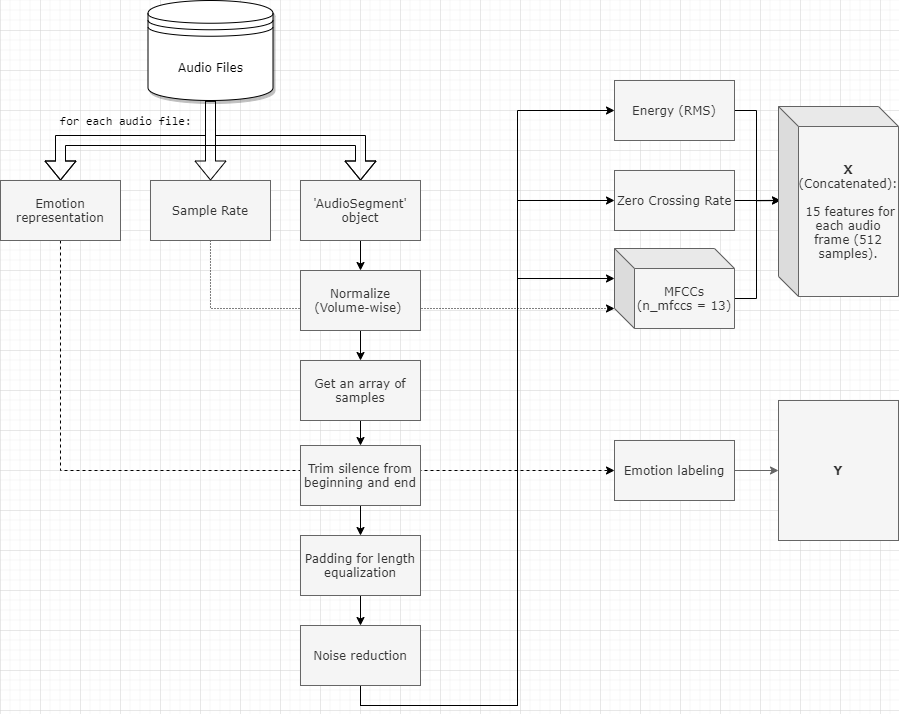

## **Initial extractions**
The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a fixed placed int that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a string representation of an emotion, e.g 'happy'.


2.   **Sample Rate**: number of audio samples per second. RAVDESS database was recorded in 48kHz, and the TESS database was recorded in 24.414kHz.

3. **The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the `AudioSegment` module of `pydub`.
*   Normalization: The 'AudioSegment' object is normalized to + 5.0 dBFS, by `effects` module of `pydub`.
*   Transforming the object to an array of samples by `numpy` & `AudioSegment`.
*   Trimming the silence in the beginning and the end by `librosa`.
*   Padding every audio file to the maximum length by `numpy`, for length equalization.
*   Noise reduction is being performed by `noisereduce`.
---
















## **Features extraction**
The selected features being extracted with `librosa` for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs)

With `frame_length = 2048`, `hop_lentgh = 512`, assuring equally sequential length.

**Explanation:**

Every 2048 samples (sequence of ~0.058 seconds on average) are being analyzed and translated to 4 sequential feature values (2048 / 512 = 4).

In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

Audio preprocess and feature extraction is presented for a single audio file in "1_preprocess_for_one_audiofile" notebook.

## **Emotion representation**
There is a different representation of the emotions in each database.

#### **RAVDESS Database**

*   A RAVDESS filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). The format which carries only emotion expressed by speech is taken as 03-01-X-X-X-X-X.wav, as the 8 emotions are stated in the 3rd part (The 1st 'X' within the file-name format).


#### **TESS Database**

*   A TESS file name contains the emotion by a direct text, e.g. "YAF_youth_happy.wav".

*    To overcome this incompatibility with the RAVDESS representation, "find_emotion" function has been executed.


In addition, classification modeling accepting only values starting from zero, thus "emotionfix" function has been executed for all files, performing an 'n = n-1' process for the emotion representation.


In [63]:
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [64]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/home/group02-f24/Documents/Zoghby/Audio'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


## **THE PREPROCESS**
Following the preprocessing presentation for a single audio file in "1_preprocess_for_one_audiofile" notebook, the full data will be preprocessed and extracted as the speech features chosen.

In [65]:
import time

# Preprocess a single audio file
def preprocess_audio_file(file_path, total_length=173056, target_sr=22050, top_db=30):
    # Load using pydub (for normalization)
    rawsound = AudioSegment.from_file(file_path)
    normalized = effects.normalize(rawsound, headroom=5.0)
    samples = np.array(normalized.get_array_of_samples(), dtype='float32')
    # Scale to [-1, 1] assuming 16-bit audio
    max_val = float(2 ** (8 * rawsound.sample_width - 1))
    samples = samples / max_val
    
    # Trim silence
    trimmed, _ = librosa.effects.trim(samples, top_db=top_db)
    
    # Pad or truncate to a fixed total_length
    if len(trimmed) < total_length:
        padded = np.pad(trimmed, (0, total_length - len(trimmed)), mode='constant')
    else:
        padded = trimmed[:total_length]
    
    # Resample if necessary
    sr_orig = rawsound.frame_rate
    if sr_orig != target_sr:
        padded = librosa.resample(padded, orig_sr=sr_orig, target_sr=target_sr)
        sr = target_sr
    else:
        sr = sr_orig

    # Noise reduction
    reduced = nr.reduce_noise(y=padded, sr=sr)
    
    return reduced, sr

# Define expected number of frames based on fixed total_length, frame_length, and hop_length
total_length = 173056
frame_length = 2048
hop_length = 512
expected_frames = 1 + int((total_length - frame_length) / hop_length)

# Extract features with fixed number of frames
def extract_features_fixed(signal, sr, frame_length=2048, hop_length=512, n_mfcc=13, expected_frames=expected_frames):
    # Basic features
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # MFCCs and derivatives
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
    # Spectral features
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=signal, sr=sr, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, hop_length=hop_length)
    
    # Stack features: shape will be (feature_dim, n_frames)
    features = np.vstack((zcr, rms, mfcc, mfcc_delta, mfcc_delta2, centroid, contrast, rolloff)).T
    current_frames = features.shape[0]
    
    # Pad or truncate the features to expected_frames along the time axis
    if current_frames < expected_frames:
        pad_width = expected_frames - current_frames
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    elif current_frames > expected_frames:
        features = features[:expected_frames, :]
        
    return features

tic = time.perf_counter()

features_list = []
emotions_list = []

folder_path = 'Audio'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(subdir, file)

         # Emotion extraction from file name
        if find_emotion_T(file) != "-1":
            code = find_emotion_T(file)
        else:
            code = file[6:8]

        if code in ["02", "08"]:
            continue   

        # Preprocess the audio file
        final_x, sr = preprocess_audio_file(file_path, total_length=total_length, target_sr=22050, top_db=30)
        # Extract features with fixed number of frames
        feats = extract_features_fixed(final_x, sr, frame_length=frame_length, hop_length=hop_length, n_mfcc=13, expected_frames=expected_frames)
        features_list.append(feats)
        emotions_list.append(emotionfix(code))
        
       

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:.4f} minutes")

# Convert the list of features to a NumPy array
X = np.array(features_list, dtype='float32')
print("X shape:", X.shape)

# Prepare labels
Y = np.array(emotions_list, dtype='int8')
Y = np.expand_dims(Y, axis=1)


Running time: 2.6597 minutes
X shape: (3456, 335, 50)


In [68]:
# all Y labels printing
print("Y shape:", Y.shape)
print("Y labels:", Y)

Y shape: (3456, 1)
Y labels: [[2]
 [2]
 [2]
 ...
 [4]
 [3]
 [6]]


# **FINAL DATA SETUP**
In order to input the data into a model, a few adjustments should be made:


*   The shapes of the features must be uniform, and in the 3D format:

 **(batch, timesteps, feature)**
*   Concatenating all features to a single 'X' variable.
*   Adjustment of 'Y' with a 2D shape (keras library requirement)
*   Split of X, Y to train, validation, and test sets.
*   y_train and y_validation conversion to 'One-hot' vectors for classification purposes (y_test is being converted adjacent to the test)




**X, Y Setup**

**Save & Load X,Y to JSON files**

In [69]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist()
x_path = 'Weights/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = 'Weights/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


'[[2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2]

In [70]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = 'Weights/X_datanew.json'# FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = 'Weights/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')


*   **Split X, Y To Train, Validation, and Test Sets**
*   **y_train and y_val conversion to One-Hot vectors.**



In [79]:
mapping = {0:5,2:2,3:3,4:0,5:1,6:4}
Y = np.vectorize(mapping.get)(Y)

In [80]:
Y

array([[2],
       [2],
       [2],
       ...,
       [0],
       [3],
       [4]])

In [81]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 6)
y_val_class = tf.keras.utils.to_categorical(y_val, 6)

In [82]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3024, 335, 50)
(300, 335, 50)
(132, 335, 50)


In [ ]:
# Save x_test, y_test to JSON.

file_path = 'Weights/x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'Weights/y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[3], [3], [1], [2], [5], [1], [5], [2], [0], [0], [1], [1], [1], [2], [1], [5], [2], [3], [5], [3], [1], [4], [2], [5], [4], [5], [4], [3], [4], [4], [0], [0], [5], [2], [5], [1], [5], [2], [1], [1], [3], [1], [2], [2], [3], [1], [4], [5], [3], [4], [2], [4], [1], [3], [1], [1], [1], [1], [4], [4], [4], [3], [0], [5], [2], [3], [1], [4], [0], [3], [5], [4], [5], [4], [5], [2], [5], [0], [0], [5], [1], [0], [1], [0], [0], [0], [4], [2], [2], [0], [4], [5], [2], [1], [3], [2], [3], [3], [1], [5], [1], [3], [3], [2], [2], [1], [1], [3], [4], [5], [5], [5], [1], [5], [2], [0], [5], [0], [2], [0], [4], [4], [4], [3], [3], [1], [5], [4], [1], [4], [4], [1]], "dtype": "int64", "shape": [132, 1], "Corder": true}'

# **MODEL DEFINITION & TRAIN**
The model is executed with keras library, using 2 hidden LSTM layers with 64 nodes, and an output (dense) layer with 8 nodes, each for one emotion using the 'softmax' activation.
The optimizer that led to the best results was 'RMSProp' with default parameters.

The batch size chosen is 23, which is a factor of all samples in the sets; train (3703), validation (368) and test (161).

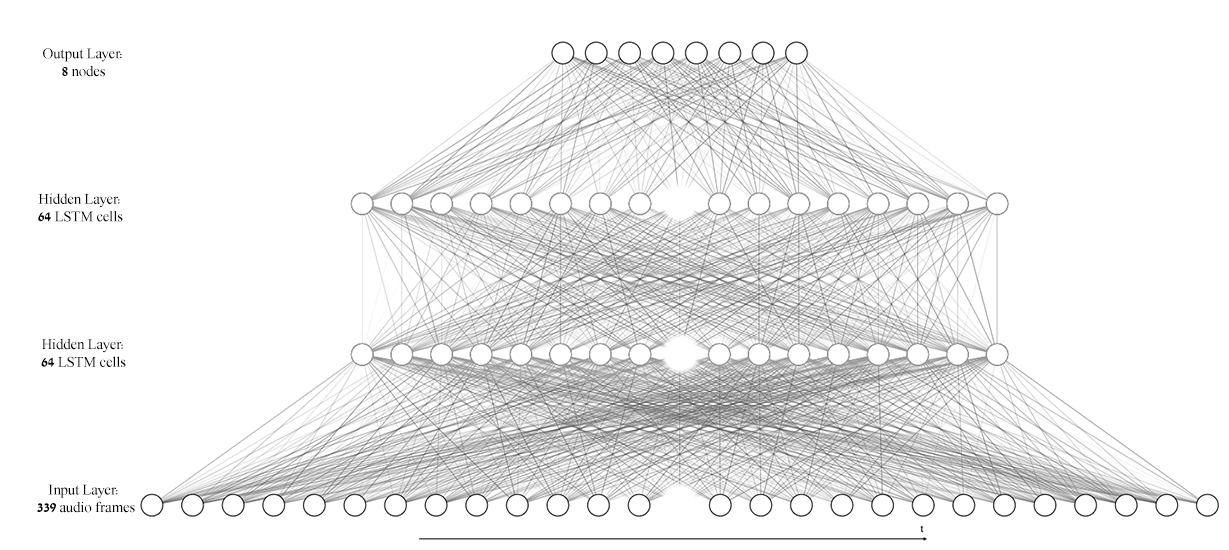

In [84]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [134]:
input_shape = X.shape[1:]  # e.g., (timesteps, features)

model = Sequential()

# Convolutional front-end with L2 regularization
model.add(layers.Conv1D(
    64, 
    kernel_size=5, 
    activation='relu', 
    input_shape=input_shape,
    kernel_regularizer=regularizers.l2(1e-4)
))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))  # increased dropout

# Bidirectional LSTM layers with L2 regularization and increased dropout
model.add(layers.Bidirectional(
    layers.LSTM(128, 
                return_sequences=True, 
                kernel_regularizer=regularizers.l2(1e-4))
))
model.add(layers.Dropout(0.4))
model.add(layers.Bidirectional(
    layers.LSTM(64, 
                kernel_regularizer=regularizers.l2(1e-4))
))
model.add(layers.Dropout(0.4))

# Fully connected layers with L2 regularization
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(6, activation='softmax'))

print(model.summary())

batch_size = 23



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 331, 64)        │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 331, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 165, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 165, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 165, 256)       │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 165, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,950 (1.48 MB)

 Trainable params: 386,822 (1.48 MB)

 Non-trainable params: 128 (512.00 B)

None


In [135]:
# Define checkpoint path
checkpoint_path = 'Weights/best_weights.keras'

# Callback: Save the best weights based on validation categorical accuracy
mcp_save = callbacks.ModelCheckpoint(
    checkpoint_path, 
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max'
)

# Callback: Reduce learning rate if validation accuracy doesn't improve
rlrop = callbacks.ReduceLROnPlateau(
    monitor='val_categorical_accuracy', 
    factor=0.1, 
    patience=20  # reduced patience for quicker reaction
)

# Callback: Early stopping to halt training when improvement stalls
early_stop = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=20, 
    restore_best_weights=True
)

# Compile with Adam optimizer
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=1e-3), 
    metrics=['categorical_accuracy'])

In [ ]:

# Train the model (340 epochs is kept, but early stopping should prevent overfitting)
history = model.fit(
    x_train, y_train_class, 
    epochs=340, 
    batch_size=batch_size, 
    validation_data=(x_val, y_val_class), 
    callbacks=[mcp_save, rlrop, early_stop]
)

# Load the best model weights
model.load_weights(checkpoint_path)

# **MODEL EVALUATION**
The model has been evaluated using the following factors:


1.   A visualization of the loss and categorial accuracy values trend during the train process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion: for validation and test sets.
3.   Model's prediction accuracy rates for each emotion: for validation and test sets.


In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## **Train (fit) Visualization**

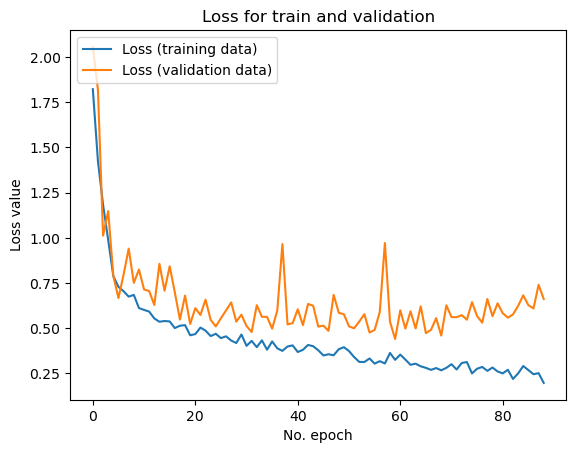

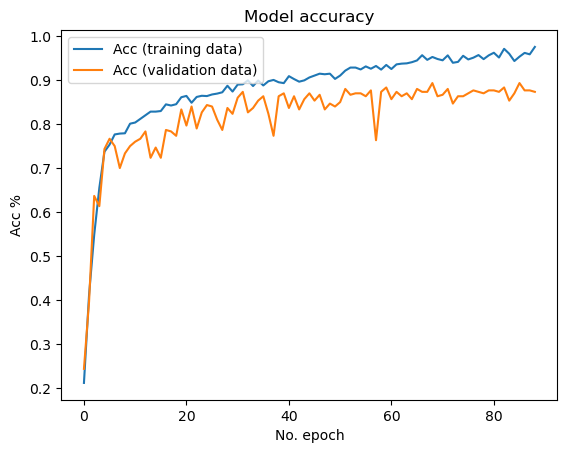

In [125]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **Validation Set Evaluation**

**Val Set Score**

In [ ]:
model = keras.models.load_model("FinalWeights1/best_weights.keras")

In [139]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

10/10 - 0s - 48ms/step - categorical_accuracy: 0.9067 - loss: 0.4232


**Val Set Confussion Matrix**

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


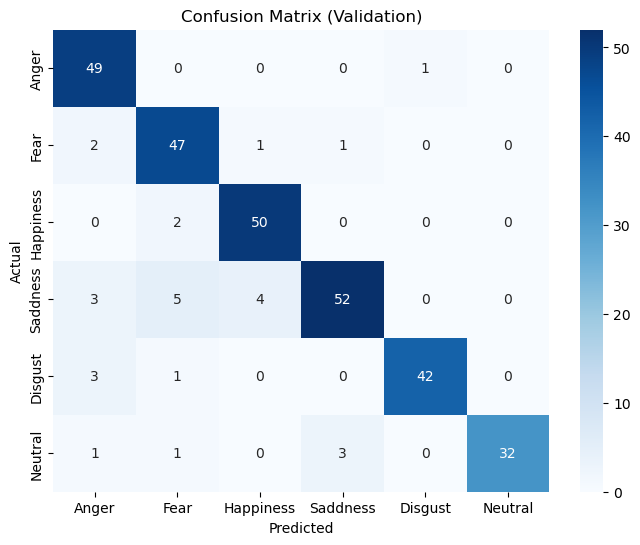

In [140]:
import pandas as pd

# Predict
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

# Fix ground truth labels
if len(y_val_class.shape) > 1:
    y_true = np.argmax(y_val_class, axis=1)
else:
    y_true = y_val_class

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_class)

labels = ['Anger', 'Fear', 'Happiness', 'Saddness', 'Disgust', 'Neutral']

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Optional: visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.show()


**Validation Set Predicted emotions accuracy**

In [50]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
48128 : 0.8649
156672 : 0.9038


IndexError: index 2 is out of bounds for axis 0 with size 2

## **Save & Load model, weights**


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = 'Weights/model8723.json'
saved_weights_path = 'Weights/model8723.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


# Loading

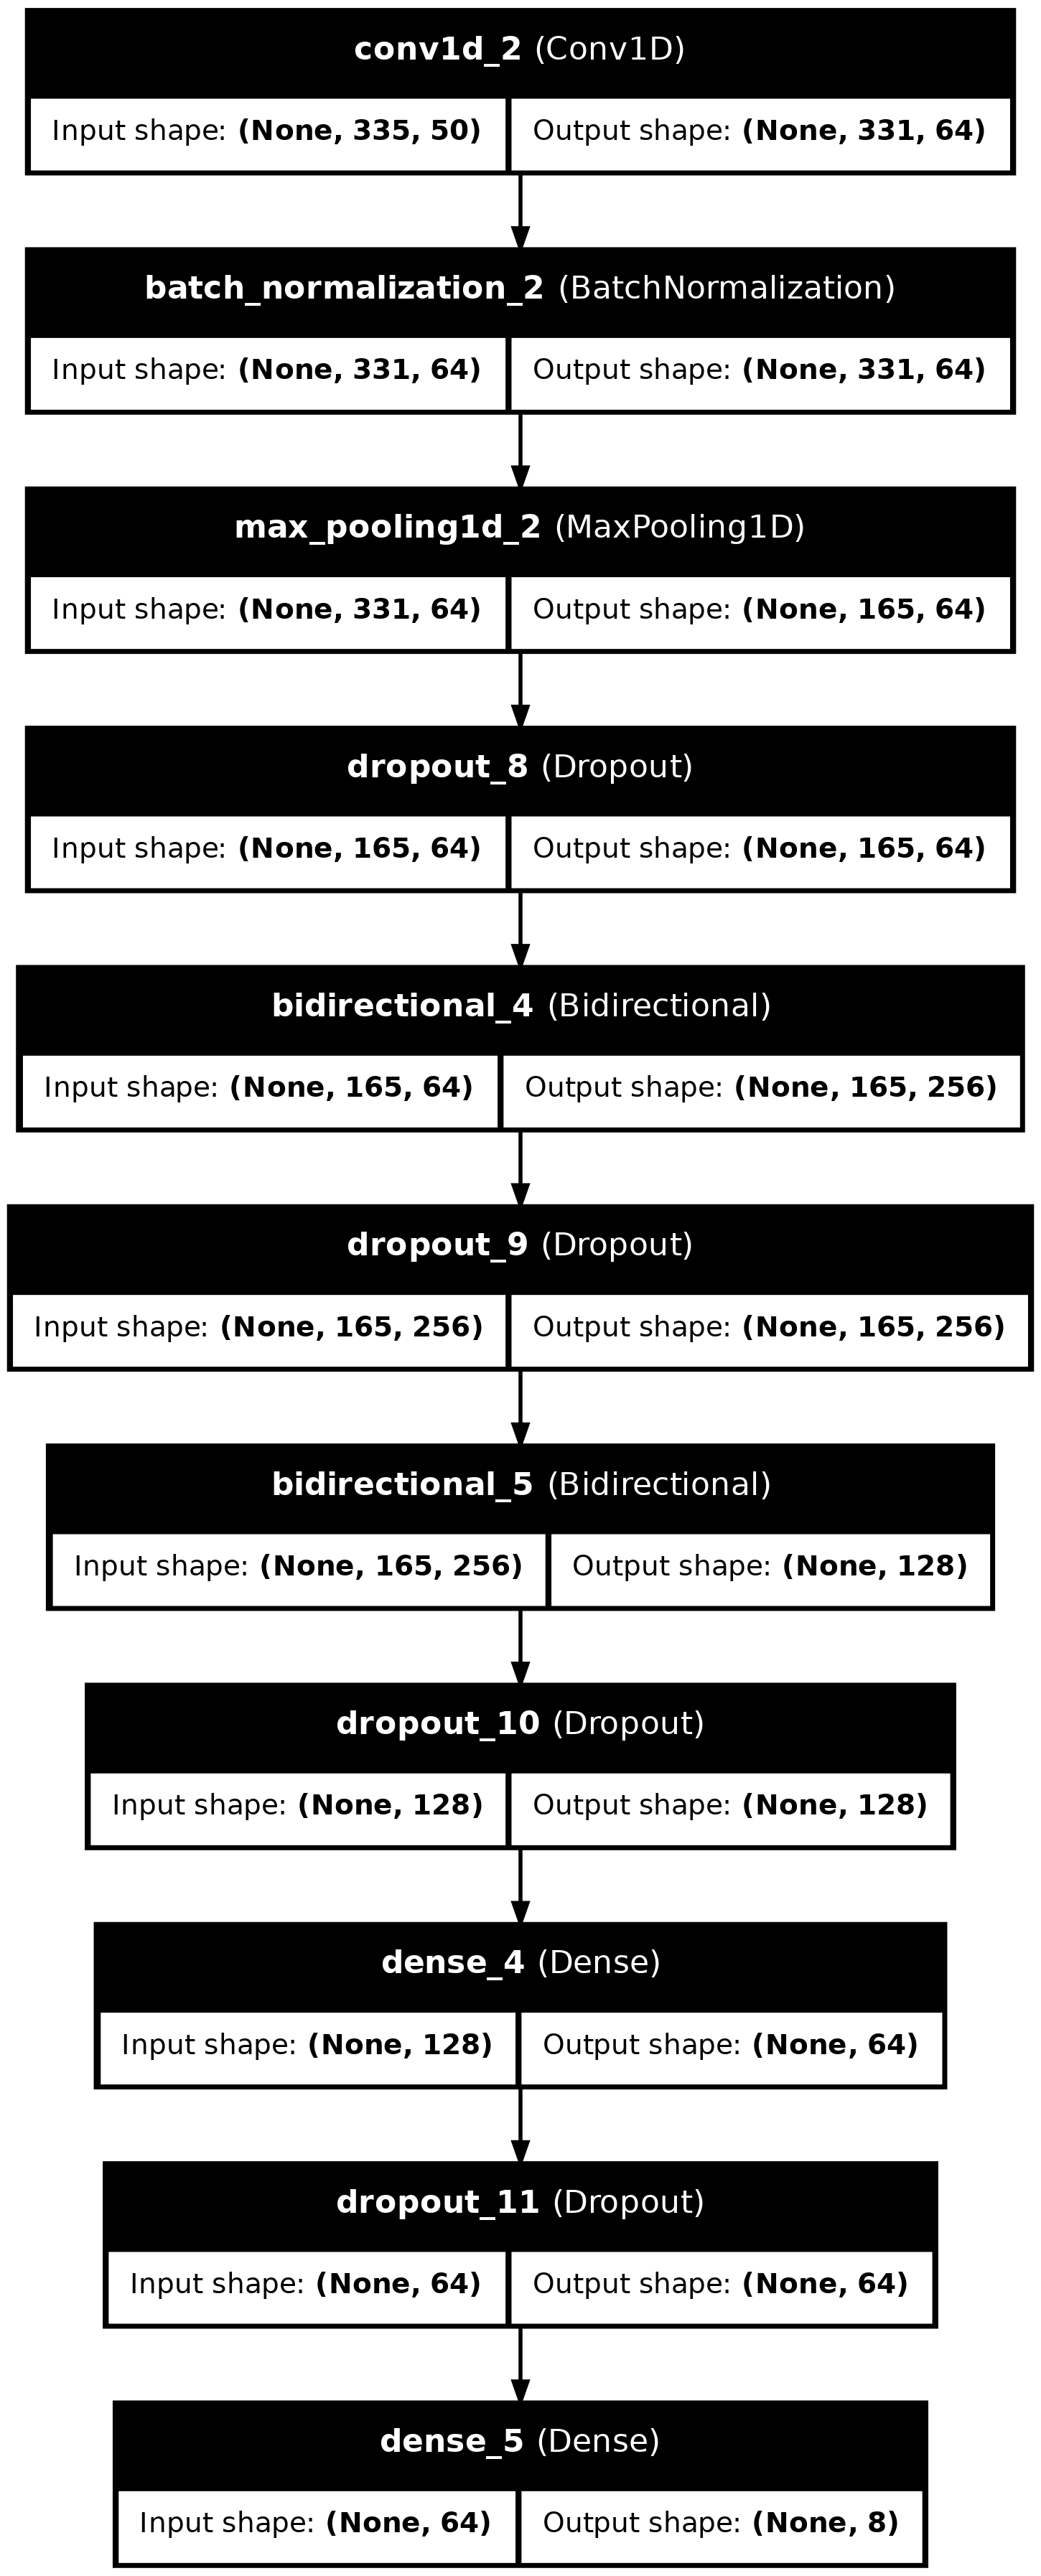

In [ ]:
# Reading the model from JSON file

saved_model_path = 'Weights/model8723.json'
saved_weights_path = 'Weights/model8723.weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [53]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8)

## **Test Set Evaluation**

**Test Set Score**

In [54]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

5/5 - 0s - 88ms/step - categorical_accuracy: 0.8561 - loss: 0.4262


**Test Set Confussion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


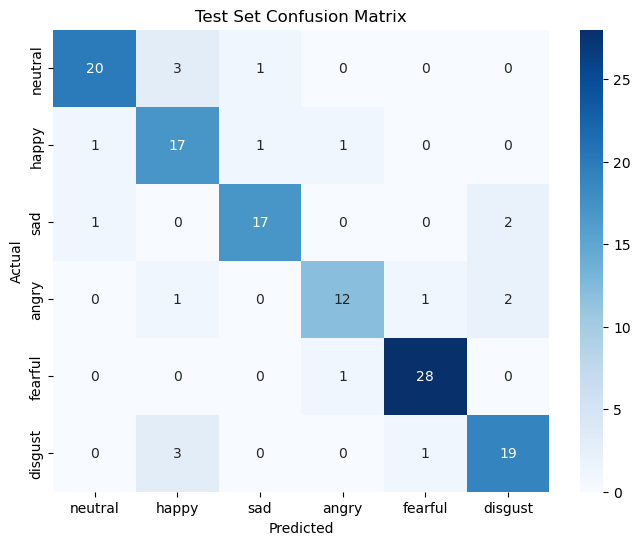

In [55]:
# Predict
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

# Convert y_test_class only if needed
if len(y_test_class.shape) > 1:
    y_true = np.argmax(y_test_class, axis=1)
else:
    y_true = y_test_class

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']


cm = confusion_matrix(y_true, y_pred_class)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


**Test Set Predicted emotions accuracy**

In [56]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
48128 : 0.8333
156672 : 0.8500


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
def predict_single_file(model, file_path, total_length=173056, target_sr=22050, top_db=30,
                        frame_length=2048, hop_length=512, n_mfcc=13, expected_frames=335):
    """
    Predict the emotion of a single audio file using the trained model.
    
    Parameters:
      model         : Trained model to use for prediction.
      file_path     : Path to the audio file.
      total_length  : Fixed total length for audio (in samples).
      target_sr     : Target sample rate (Hz).
      top_db        : Decibel threshold for trimming silence.
      frame_length  : Frame length for feature extraction.
      hop_length    : Hop length for feature extraction.
      n_mfcc        : Number of MFCCs to extract.
      expected_frames: Expected number of frames in the feature matrix.
    
    Returns:
      predictions   : Raw prediction probabilities (NumPy array).
      predicted_emotion: Mapped emotion label (string).
    """
    # Preprocess the audio file
    signal, sr = preprocess_audio_file(file_path, total_length=total_length, target_sr=target_sr, top_db=top_db)
    
    # Extract features with fixed number of frames
    features = extract_features_fixed(signal, sr, frame_length=frame_length, hop_length=hop_length, 
                                      n_mfcc=n_mfcc, expected_frames=expected_frames)
    # Expand dimensions to create a batch of 1 sample
    X_input = np.expand_dims(features, axis=0)
    
    # Predict using the trained model
    predictions = model.predict(X_input)
    
    # Map predicted index to emotion
    predicted_class = np.argmax(predictions, axis=1)[0]
    emotion_map = {
        0: 'Angry',
        1: 'Fear',
        2: 'Happiness',
        3: 'sad',
        4: 'Disgust',
        5: 'Neutral',
    }
    predicted_emotion = emotion_map.get(predicted_class, "Unknown")
    
    print("Raw prediction probabilities:", predictions)
    print("Predicted Emotion:", predicted_emotion)
    
    return predictions, predicted_emotion

# Example usage:
file_path = ""
predictions, predicted_emotion = predict_single_file(model, file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Raw prediction probabilities: [[0.0062456  0.00936817 0.95888084 0.01222551 0.00191613 0.01136379]]
Predicted Emotion: Happiness


# **RESULTS & CONCLUSIONS**
As seen, the validation set accuracy of the model had come up to 87.23% and the test set accuracy had reached 84.47% with overfitting in the training process starting around the 100th epoch. Although various regulations have been placed in earlier tryouts, they had restricted the accuracy from reaching its maximum value. A ModelCheckpoint is applied, saving the best weights according to the model's accuracy, thus the overfitting is bypassed.

Within the next part of the study in which the model will be used as a Real-time SER, The inputs will be processed similarly as the data used by the model, to gain similarity and therefore, precision.

In [63]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 331, 64)        │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 331, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 165, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 165, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 165, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 165, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,080 (1.48 MB)

 Trainable params: 386,952 (1.48 MB)

 Non-trainable params: 128 (512.00 B)